In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Supress MatPlotLib Warning

In [2]:
NORMAL = -0.25
TREASURE = 5
OBSTICLE = 0
OPPONENT = -5

These are the ground type reward amounts.

They can be seen as simulating a real-life scenario.

Normal ground is set to -0.25. This can be seen as like a gas/resource cost to traverse each space. This is set to a negative value to motivate shorter paths as gas isn't free.

The value for an Obsticle does not matter as that block type will never be crossed over.

Opponents can be seen as simulating a bandit who will take 5 points away from you if you go through them, and each treasure found will add 5 to the total rewards.

In [3]:
def printMap(M, path=None):
    cmap = mpl.colors.ListedColormap(['blue', 'saddlebrown', 'gold','forestgreen'])
    M_copy = np.copy(M)

    '''
    Scaling the Map for colormesh
    '''
    
    minimum = int(np.amin(M))-1
    M_copy[abs(M_copy - NORMAL) < .01]   = minimum-1
    M_copy[abs(M_copy - TREASURE) < .01] = minimum-2
    M_copy[abs(M_copy - OBSTICLE) < .01] = minimum-3
    M_copy[abs(M_copy - OPPONENT) < .01] = minimum-4

    M_copy[M_copy is minimum-1] = 0
    M_copy[M_copy is minimum-2] = 1
    M_copy[M_copy is minimum-3] = 2
    M_copy[M_copy is minimum-4] = 3
    

    plt.pcolormesh(M_copy, cmap=cmap)

    green_patch = mpl.patches.Patch(color='forestgreen', label='Normal Ground')
    gold_patch = mpl.patches.Patch(color='gold', label='Treasure')
    brown_patch = mpl.patches.Patch(color='saddlebrown', label='Obsticle')
    blue_patch = mpl.patches.Patch(color='blue', label='Opponent')
    handles = [green_patch, gold_patch, brown_patch, blue_patch]
    plt.subplots_adjust(right=0.7)
    if path is not None:
        plt.plot(*path.T, color='red')
        red_patch = mpl.patches.Patch(color='red', label='Path')
        handles.append(red_patch)
    plt.legend(handles=handles ,loc='upper left', bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.axes().set_aspect('equal') #set the x and y axes to the same scale
    plt.xticks(np.arange(0, len(M), 1)) # remove the tick marks by setting to an empty list
    plt.yticks(np.arange(0, len(M[0]), 1)) # remove the tick marks by setting to an empty list
    plt.grid()
    plt.axes().invert_yaxis() #invert the y-axis so the first row of data is at the top

In [4]:
height = 15
width = 15
'''
Map Constants
'''

'\nMap Constants\n'

In [5]:
M = np.full((width,height), NORMAL)
shape = M.shape
M = M.flatten()
np.random.seed(2)
treasureIndecies = np.random.choice(M.size, size=20)
M[treasureIndecies] = TREASURE
M = M.reshape(shape)

M[1][0] = TREASURE; M[2][1] = TREASURE; M[3][2] = TREASURE; M[4][3] = TREASURE

M[5,1] = OBSTICLE; M[6,1] = OBSTICLE; M[7,1] = OBSTICLE; M[8,1] = OBSTICLE
M[11,1] = OBSTICLE; M[12,1] = OBSTICLE; M[13,1] = OBSTICLE; M[14,1] = OBSTICLE
M[11,2] = OBSTICLE; M[11,3] = OBSTICLE; M[11,4] = OBSTICLE; M[11,5] = OBSTICLE

M[10,4] = OPPONENT; M[4,3] = OPPONENT; M[5,10] = OPPONENT; M[14,4] = OPPONENT

M[0,0] = NORMAL
M[14,14] = TREASURE

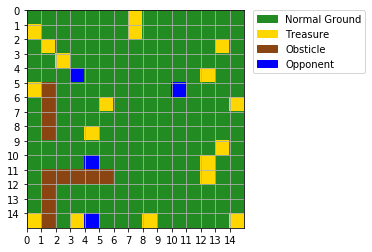

In [6]:
printMap(M)

This is an arbiturary first map we have made for testing the reinforcement learning

In [7]:
def move_state(state, move):
    '''
    This is defining the 4 different types of moves one can do from each state.
    
    The reason we do not define a stopping move is that the agent will automatically
    halt when reaching the destination block
    
    Not all of these are valid however as either it will loop you around the map or enter you into a obsticle.
    '''
    if move == 0:   # North
        return state - width
    elif move == 1: # East
        return state + 1
    elif move == 2: # South
        return state + width
    elif move == 3: # West
        return state - 1
    else:
        raise Exception

In [8]:
def get_poss_moves(s, M):
    '''
    Returns the possible moves from any arbiturary state
    '''
    poss_moves = []
    valid_moves = []
    x, y = stateToXY(s)
    if y > 0:
        valid_moves.append(0)
    if x < len(M[0]) - 1:
        valid_moves.append(1)
    if y < len(M) - 1:
        valid_moves.append(2)
    if x > 0:
        valid_moves.append(3)
    for move in valid_moves:
            poss_state = move_state(s,move)
            x,y = stateToXY(poss_state)
            if M[y][x] != OBSTICLE: poss_moves.append(move)
    return poss_moves
def get_best_next_move(s, M, Q):
    '''
    Gets the optimal move based on the Q matrix
    '''
    poss_next_moves = get_poss_moves(s, M)
    if len(poss_next_moves) == 0:
            return None
    max_m = poss_next_moves[0]
    max_q = Q[s][max_m]

    for move in poss_next_moves[1::]:
        if(Q[s][move] > max_q):
            max_q, max_m = Q[s][move], move
    return max_m

def get_rnd_next_move(s, M, Q):
    '''
    Gets the next move for either exploring or exploiting
    '''
    poss_next_moves = get_poss_moves(s, M)
    if len(poss_next_moves) == 0:
            return None
    if np.random.rand() <= exploitation_probability:
        return get_best_next_move(s, M, Q)
    else:
        next_move = \
            poss_next_moves[np.random.randint(0,\
            len(poss_next_moves))]
        return next_move

In [9]:
'''
State to position conversions
'''
def stateToXY(s):
    return s % width, s // width
def XYToState(x,y):
    return y*width+x

In [10]:
def train(M, Q, gamma, lrn_rate, goal, ns, max_epochs, startingState, max_steps):
    for _ in range(0,max_epochs):
        M_copy = np.copy(M)
        curr_s = 0
        steps = 0
        x,y = stateToXY(curr_s)
        points = M_copy[y][x]
        M_copy[y][x] = OBSTICLE # Converts the path previously walked on to disalow backtracking
        while(True):
            next_m = get_rnd_next_move(curr_s, M_copy, Q)
            if next_m is None:
                break
            next_s = move_state(curr_s,next_m)
            x,y = stateToXY(next_s)
            next_r = M_copy[y][x]
            points += next_r

            M_copy[y][x] = OBSTICLE

            bestnextnextMove = get_best_next_move(next_s, M_copy, Q)
            max_Q = -1
            if bestnextnextMove is not None:
                max_Q = Q[next_s][bestnextnextMove]
                
            Q[curr_s][next_m] = Q[curr_s][next_m] + (lrn_rate) * \
                                                    ( next_r + (gamma * max_Q) - Q[curr_s][next_m] )
            #Q matrix update based on the formula from class
            
            curr_s = next_s
            steps += 1
            if curr_s == goal: break
            if steps == max_steps: break # Max steps specified to quicken algorithm from excessively long paths. Less neccessary when backtracking is disallowed

In [11]:
def walk(start, goal, Q, M, max_steps):
    '''
    Returning a path based on the best move from the highest values in the Q matrix
    '''
    M_copy = np.copy(M)
    
    steps = 1
    curr = start
    curr_x, curr_y = stateToXY(curr)
    points = M_copy[curr_y][curr_x]
    M_copy[curr_y][curr_x] = OBSTICLE
    print(str((curr_x,curr_y)), end="")
    path = [[.5,.5]]
    while curr != goal and steps < max_steps:
        next_m = get_best_next_move(curr, M_copy, Q)
        if next_m is None:
            break
        next = move_state(curr,next_m)
        curr_x, curr_y = stateToXY(curr)
        x, y = stateToXY(next)
        path.append([x+.5,y+.5])
        print("->" + str((x,y)), end="")
        points += M_copy[y,x]
        M_copy[y][x] = OBSTICLE

        curr = next
        steps += 1
        
    return np.array(path),points

In [12]:
start_state = 0
state_count = M.size
final_state = state_count - 1
move_options = 4
gamma = .5
lrn_rate = .2
max_epochs = 1000
max_steps = 100
exploitation_probability = .8

Parameters chosen based on some parameter tweaking to optimise for speed of training and optimality of path

In [13]:
Q = np.zeros(shape=[state_count,move_options], dtype=np.float32)  # Quality
train(M, Q, gamma, lrn_rate, final_state, state_count, max_epochs, 0, max_steps)

In [14]:
print("Path from", stateToXY(start_state), "to", stateToXY(final_state))
path,points = walk(start_state, final_state, Q, M, max_steps)

Path from (0, 0) to (14, 14)
(0, 0)->(0, 1)->(0, 2)->(1, 2)->(2, 2)->(2, 3)->(1, 3)->(0, 3)->(0, 4)->(0, 5)->(0, 6)->(0, 7)->(0, 8)->(0, 9)->(1, 9)->(2, 9)->(2, 8)->(3, 8)->(4, 8)->(4, 7)->(4, 6)->(5, 6)->(6, 6)->(7, 6)->(7, 5)->(7, 4)->(7, 3)->(7, 2)->(7, 1)->(7, 0)->(8, 0)->(8, 1)->(8, 2)->(9, 2)->(10, 2)->(11, 2)->(12, 2)->(13, 2)->(13, 3)->(12, 3)->(12, 4)->(13, 4)->(14, 4)->(14, 5)->(14, 6)->(14, 7)->(13, 7)->(13, 8)->(13, 9)->(13, 10)->(12, 10)->(12, 11)->(13, 11)->(14, 11)->(14, 12)->(14, 13)->(14, 14)

Total rewards for path is: 64.5


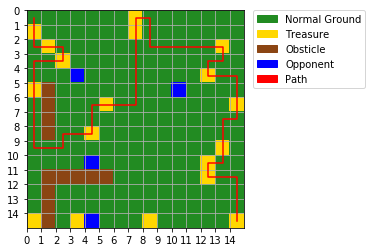

In [15]:
printMap(M,path)
print("Total rewards for path is:", points)

That's the algorithm in action!
Overall, we are very impressed by the results.

Q-Learning is very simple to understand and it has achieved great results.

We can see that this is not the most optimal path. From the treasure at (12,11), the path getting the treasure at (8,14) before going to the end of the path would increase the total path length by 8 which would cost 2, but the added treasure would increase rewards by 5 increasing the total reward to 67.5.

Overall, thus path being above 95% optimal is fantastic for how efficient Q-Learning is.

Lets re-train over the same map and see if we get the same results.

Path from (0, 0) to (14, 14)
(0, 0)->(0, 1)->(0, 2)->(1, 2)->(2, 2)->(2, 3)->(1, 3)->(0, 3)->(0, 4)->(0, 5)->(0, 6)->(0, 7)->(0, 8)->(0, 9)->(1, 9)->(2, 9)->(3, 9)->(3, 8)->(4, 8)->(4, 7)->(4, 6)->(5, 6)->(6, 6)->(7, 6)->(7, 5)->(7, 4)->(7, 3)->(7, 2)->(7, 1)->(7, 0)->(8, 0)->(8, 1)->(8, 2)->(9, 2)->(10, 2)->(10, 3)->(10, 4)->(11, 4)->(12, 4)->(12, 3)->(13, 3)->(13, 2)->(14, 2)->(14, 3)->(14, 4)->(14, 5)->(14, 6)->(14, 7)->(13, 7)->(13, 8)->(13, 9)->(13, 10)->(12, 10)->(12, 11)->(13, 11)->(13, 12)->(14, 12)->(14, 13)->(14, 14)
Total rewards for path is: 64.0


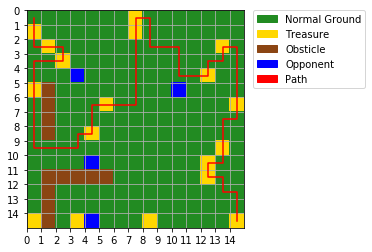

In [16]:
Q = np.zeros(shape=[state_count,move_options], dtype=np.float32)
train(M, Q, gamma, lrn_rate, final_state, state_count, max_epochs, 0, max_steps)
print("Path from", stateToXY(start_state), "to", stateToXY(final_state))
path,points = walk(start_state, final_state, Q, M, max_steps)
printMap(M,path)
print("\nTotal rewards for path is:", points)

This training achieved a path that was slightly less optimal than prior. We can see that it takes a slightly different path to get to the same peices of treaure that the prior run gave. Overall though it a decrease in total rewards by less than 1%.

We might be able to adjust our parameters to acheive a more optimal path more often, but I am happy with how quickly these parameters run with training.

Lets try this on another map

In [17]:
M = np.full((width,height), NORMAL)
shape = M.shape
M = M.flatten()
treasureIndecies = np.random.choice(M.size, size=15)
obsticleIndecies = np.random.choice(M.size, size=20)
opponentIndecies = np.random.choice(M.size, size=5)

M[treasureIndecies] = TREASURE
M[obsticleIndecies] = OBSTICLE
M[opponentIndecies] = OPPONENT

M = M.reshape(shape)

M[0,0] = NORMAL
M[14,14] = TREASURE

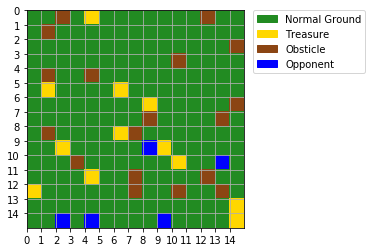

In [18]:
printMap(M)

Path from (0, 0) to (14, 14)
(0, 0)->(0, 1)->(0, 2)->(0, 3)->(0, 4)->(0, 5)->(1, 5)->(2, 5)->(2, 6)->(2, 7)->(2, 8)->(2, 9)->(2, 10)->(2, 11)->(3, 11)->(4, 11)->(4, 10)->(5, 10)->(5, 9)->(5, 8)->(6, 8)->(6, 7)->(6, 6)->(6, 5)->(7, 5)->(8, 5)->(8, 6)->(9, 6)->(9, 7)->(9, 8)->(9, 9)->(9, 10)->(10, 10)->(10, 11)->(11, 11)->(11, 12)->(11, 13)->(12, 13)->(13, 13)->(14, 13)->(14, 14)
Total rewards for path is: 42.25


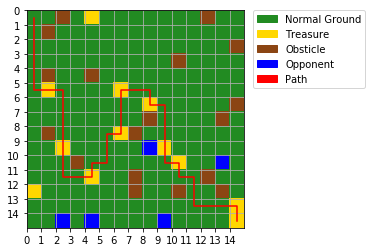

In [19]:
Q = np.zeros(shape=[state_count,move_options], dtype=np.float32)
train(M, Q, gamma, lrn_rate, final_state, state_count, max_epochs, 0, max_steps)
print("Path from", stateToXY(start_state), "to", stateToXY(final_state))
path,points = walk(start_state, final_state, Q, M, max_steps)
printMap(M,path)
print("\nTotal rewards for path is:", points)

This path is pretty good as well!
It is not optimal as the treasure at (0,12) can be traversed to in 6 additional steps and increase the total rewards by 3.5. This would put the optimal path rewards at 45.75.

Our path is 92% optimal.

Pretty good as well

This assignment was extremely insightful to us in 